# Examination of Speedrun Attempts with xpath, pandas, and manim

When gamers, youtubers, or streamers conduct speedrunning sessions, their data is saved into a .lss file; a file that stores pre-determined marker time splits in an XML format.

Pre-determined markers may be "Start," "Level 3," "Defeat Final Boss," etc. depending on the type of speedrun.

The file can prove difficult to work with without prior cleaning, as the data is noded by the pre-determined marker, not by the attempt. "Attempts" (a.k.a "runs") are one node, holding an id, a start time, and a stop time. The "Segment" nodes hold the time for all attempts.

For example: 100 speedrunning attempts of Super Mario Bros. would have the "AttemptHistory" node, which holds 100 child nodes with previously mentioned three pieces of information; the "Segments" node would hold a series of child nodes that are listed by the ascending marker order; within "Segments" are further child nodes titled "Segment," containing the "SegmentHistory" which lists each attempt's time data for that segment.

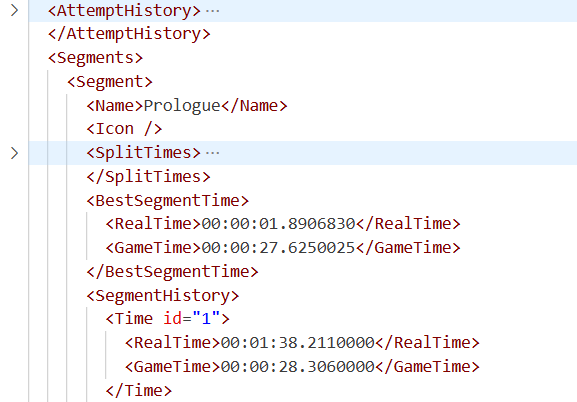

For the data contained in these nested trees, analysis is difficult and thus best converted to tabular or dataframe formats.

The following notebook will display parsing of an .lss file, parsing via XPath, then converting into a tabular csv file.

Thereafter, some explatory data analysis is performed and some visualizations are displayed.

In [1]:
#the .lss file was visually inspected to check out the segment names; some of which start with a hyphen.
#let's see the full list of segments

#import the relevant package/library
import xml.etree.ElementTree as ET

#import the file and initialize
tree = ET.parse('/content/any6bCP.lss')
root = tree.getroot()

#print split names
for seg in root.findall('.//Segment'):
    print(seg.find('Name').text)


Prologue
-Start
-Crossing
{Forsaken City} Chasm
-Start
-Intervention
{Old Site} Awake
-Start
-Huge Mess
-Elevator Shaft
{Celestial Resort} Presidential Suite
-Start
-Shrine
-Old Trail
{Golden Ridge} Cliff Face
-Start
-Cassette
-5B Start
-Central Chamber
-Through the Mirror
{Mirror Temple} Mix Master
-Start
-Lake
-Cassette
-6B Start
-Reflection
-Rock Bottom
{Reflection} Reprieve
-0m
-500m
-1000m
-1500m
-2000m
-2500m
{The Summit} 3000m


The hyphens seen on Segment names will prove annoying in tabular form, so we'll trim those now.

Likewise, there are multiple segments titled "Start" and "Cassette" which causes each value under said features to be re-written by the loops seen below. Update the names to increase iteratively.
The original stakeholder recommended aligning the "Cassettes" with their relevative Start (5, 6).

In [2]:
#run a for loop to remove the hyphen from affected segment names

for seg in root.findall('.//Segment'):
  title_hyphen = seg.find('Name')
  if title_hyphen is not None:
    title_text = title_hyphen.text or ""
    if title_text.startswith("-"):
      title_hyphen.text = title_text[1:]

all_starts = [
    seg for seg in root.findall('.//Segment')
    if seg.find('Name').text == "Start"
]

i = 1
for seg in all_starts:
  title_node = seg.find('Name')
  if title_node is not None:
    text = title_node.text or ""
    if text.startswith("Start"):
      title_node.text = (title_node.text + str(i))
      i+=1

#subset "Cassette" segments and differenciate
all_cassettes = [
    seg for seg in root.findall('.//Segment')
    if seg.find('Name').text == "Cassette"
]

cas = 5
for seg in all_cassettes:
  title_node = seg.find('Name')
  if title_node is not None:
    text = title_node.text or ""
    if text.startswith("Cassette"):
      title_node.text = (title_node.text + str(cas))
      cas+=1

In [3]:
#print split names to confirm changes
for seg in root.findall('.//Segment'):
    print(seg.find('Name').text)

Prologue
Start1
Crossing
{Forsaken City} Chasm
Start2
Intervention
{Old Site} Awake
Start3
Huge Mess
Elevator Shaft
{Celestial Resort} Presidential Suite
Start4
Shrine
Old Trail
{Golden Ridge} Cliff Face
Start5
Cassette5
5B Start
Central Chamber
Through the Mirror
{Mirror Temple} Mix Master
Start6
Lake
Cassette6
6B Start
Reflection
Rock Bottom
{Reflection} Reprieve
0m
500m
1000m
1500m
2000m
2500m
{The Summit} 3000m


In [4]:
#save as a new file for preservation
tree.write("splits_updated.xml", encoding="utf-8", xml_declaration=True)

## Converting the data into a tabular format (csv).

The original stakeholder of this project wanted the data converted into a tabular format with observations as one run, and features as segment names (e.g. ascending markers from start to finish of the speedrun). The cell value is time in duration of the run in seconds.  

Thus, extract the segment names to be column names and order them appropriately.
The time splits in the .lss file are formatted as hh:mm:ss.fraction, so parse them to convert to seconds.

Finish by writing the data to a csv.

In [5]:
#import relevant packages / libraries

import re
from collections import defaultdict, OrderedDict
import csv

#use the new file with updated segment names and prep the output file

LSS_PATH = "/content/splits_updated.xml"
CSV_OUT = "attempts_cumulative_s.csv"


#in order to parse the formatting of the time splits in the .lss, use regular expression
#to convert from strings to numerical values

_time_re = re.compile(
    r'^(?:(?P<days>\d+)\.)?(?P<h>\d{1,2}):(?P<m>\d{2}):(?P<s>\d{2})(?:\.(?P<f>\d{1,9}))?$'
)

#convert the time values to a seconds integer

def parse_time_to_s(text):
    """
    parse LiveSplit time like:
    '00:12:34.567' (d.hh:mm:ss.fff) → seconds (int).
    returns None if text is empty/invalid.
    """
    if not text:
        return None
    m = _time_re.match(text.strip())
    if not m:
        return None
    days = int(m.group("days") or 0)
    h = int(m.group("h"))
    mi = int(m.group("m"))
    s = int(m.group("s"))
    f = m.group("f")
    frac = 0
    if f:
      frac = int(f) / (10 ** len(f))
    total_s = (((days*86400 + h)*3600 + mi)*60 + s)+frac
    return total_s

#load the XML and initiatize the root

tree = ET.parse(LSS_PATH)
root = tree.getroot()

#get ordered segment names

segments_node = next((n for n in root.iter() if n.tag == "Segments"), None)

segment_names = []
for seg in segments_node:
    if seg.tag == "Segment":
        name_node = next((c for c in seg if c.tag == "Name"), None)
        segment_names.append(name_node.text if name_node is not None else "")


#collect per-attempt per-segment, segment times using GameTime
attempt_segment_s = defaultdict(dict)

for seg in segments_node:
    if seg.tag != "Segment":
        continue
    seg_name = next((c.text for c in seg if c.tag == "Name"), "")
    hist = next((c for c in seg if c.tag == "SegmentHistory"), None)
    if hist is None:
        continue
    for t in hist:
        if t.tag != "Time":
            continue
        att_id = t.get("id")
        rt = next((c.text for c in t if c.tag == "GameTime"), None)
        s = parse_time_to_s(rt)
        if att_id and s is not None:
            attempt_segment_s[att_id][seg_name] = s

#collect data into rows
rows = OrderedDict()

attempts_id_sorted = sorted(attempt_segment_s.keys(), key = lambda x: len(x))

for att_id in attempts_id_sorted:
    row = []
    for seg_name in segment_names:
        sec = attempt_segment_s[att_id].get(seg_name)
        row.append(sec if sec is not None else "")
    rows[att_id] = row

#write output csv
with open(CSV_OUT, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["attempt_id"] + segment_names)
    for att_id, vals in rows.items():
        w.writerow([att_id] + vals)

print(f"Wrote {CSV_OUT} with {len(rows)} attempts and {len(segment_names)} segments.")

#print a row sample to verify
first_id = next(iter(rows))
print(first_id, rows[first_id])

Wrote attempts_cumulative_s.csv with 3796 attempts and 35 segments.
1 [28.306, 19.209, 31.824, 29.971, 36.992, 70.839, 11.968, 69.343, 104.907, 41.106, 62.56, 63.41, 19.533, 68.34, 43.741, 33.847, 41.99, 25.16, 119.612, 74.477, 50.371, 19.533, 37.179, 10.914, 131.902999, 112.914, 103.887, 108.919, 44.948, 53.907, 49.283, 82.075999, 88.366, 89.811, 200.872]


# Exploratory Data Analysis

Now the data is available in tabaular format so let's perform some exploratory data analysis.

In [6]:
#Import the relevant packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
#import the cleaned csv file

speedrun = pd.read_csv('/content/attempts_cumulative_s.csv')

print(speedrun.head)

<bound method NDFrame.head of       attempt_id   Prologue     Start1   Crossing  {Forsaken City} Chasm  \
0              1  28.306000  19.209000  31.824000              29.971000   
1              2  28.288000  19.448000  23.035000              20.400000   
2              3  28.679000  18.275000  23.086000                    NaN   
3              4  28.356000  18.037000  25.550999              24.412000   
4              6  28.255000  17.509000  24.803000              22.695000   
...          ...        ...        ...        ...                    ...   
3791        6142  27.727003  15.877999  21.658000              18.853001   
3792        6144  27.829002  15.895000  21.403001              18.836000   
3793        6147  27.948857  16.948149  21.929996              18.921002   
3794        6149  27.846002  15.980001  21.607001              18.784999   
3795        6150  27.880002  15.878001  21.658000              19.210000   

         Start2  Intervention  {Old Site} Awake     Start

In [8]:
#save to a DataFrame and inspect summary stats

speedrun_df = pd.DataFrame(speedrun)

speedrun_df.describe()

,attempt_id,Prologue,Start1,Crossing,{Forsaken City} Chasm,Start2,Intervention,{Old Site} Awake,Start3,Huge Mess,...,Reflection,Rock Bottom,{Reflection} Reprieve,0m,500m,1000m,1500m,2000m,2500m,{The Summit} 3000m
count,3796.000000,3794.000000,3143.000000,2011.000000,1445.000000,1279.000000,1060.000000,990.000000,835.000000,711.000000,...,310.000000,304.000000,299.000000,274.000000,269.000000,267.000000,261.000000,260.000000,259.000000,259.000000
mean,3061.837724,27.977945,16.593358,23.064290,19.593483,33.614183,56.783031,9.510521,63.508172,95.006090,...,71.248155,57.161658,70.163490,41.396739,46.481792,45.153464,56.308429,76.046296,67.562004,156.976948
std,1817.737275,0.286744,1.537538,4.645983,1.621563,1.072488,2.406497,2.406913,6.120770,6.918902,...,9.780726,10.328423,13.640525,5.013718,5.608634,3.181329,9.578840,8.101056,7.822416,14.906529
min,-1.000000,27.625003,15.690999,20.893000,17.799001,32.759000,54.723001,7.530999,60.638999,90.525000,...,63.087000,50.302998,58.088998,38.590002,42.364000,42.687000,49.622999,68.663000,62.389998,139.314998
25%,1415.750000,27.880002,16.013356,21.759999,18.887000,33.065001,55.454000,7.701001,61.200000,92.097501,...,64.294000,50.830000,59.516998,39.049003,43.078001,43.171500,50.524000,70.171750,63.291000,146.199998
50%,3050.500000,27.982001,16.150000,21.980996,19.125000,33.268999,56.066001,9.086499,62.202997,93.619000,...,67.906500,52.190000,66.214998,39.499503,43.928000,43.741002,52.445000,72.666500,64.770001,152.591998
75%,4620.500000,28.067001,16.626001,22.661000,19.686000,33.761999,57.154000,10.880001,64.523500,95.795000,...,74.383500,59.993000,75.199499,42.126002,47.650999,46.257000,58.429000,79.207249,69.020000,163.888498
max,6150.000000,43.316002,46.954000,122.094001,46.817999,50.999999,81.260000,58.004000,216.733000,216.138000,...,144.788999,120.275001,128.961999,94.673002,75.786000,63.920000,117.708000,106.879001,143.599000,236.231998


In [9]:
#investigate the amount of counts
#what's the distribution across the attempts?

counts = speedrun_df.describe()[:1]

counts = counts.drop(['attempt_id'], axis=1)

In [10]:
counts

,Prologue,Start1,Crossing,{Forsaken City} Chasm,Start2,Intervention,{Old Site} Awake,Start3,Huge Mess,Elevator Shaft,...,Reflection,Rock Bottom,{Reflection} Reprieve,0m,500m,1000m,1500m,2000m,2500m,{The Summit} 3000m
count,3794.0,3143.0,2011.0,1445.0,1279.0,1060.0,990.0,835.0,711.0,637.0,...,310.0,304.0,299.0,274.0,269.0,267.0,261.0,260.0,259.0,259.0


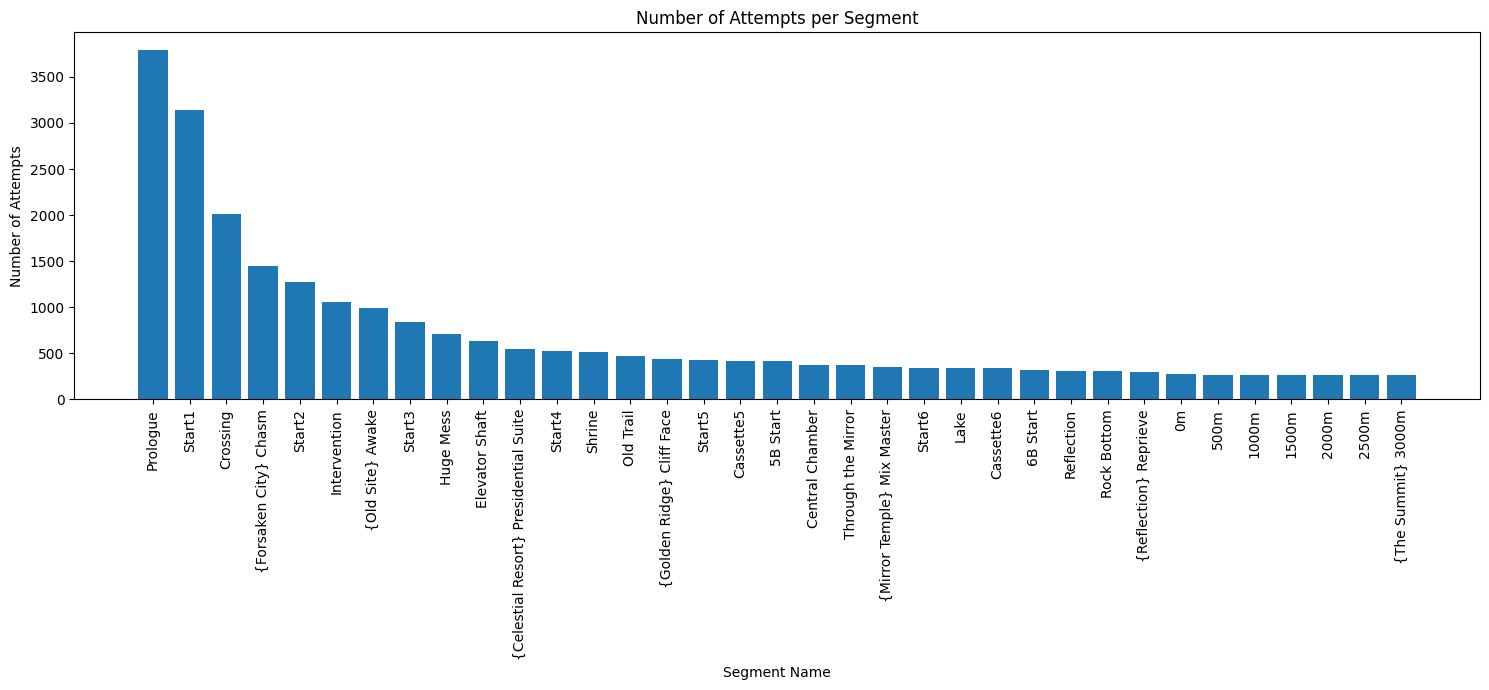

In [11]:
#plot the distribution

plt.figure(figsize=(15, 7))
plt.bar(counts.columns, counts.values[0])
plt.xticks(rotation=90)
plt.xlabel("Segment Name")
plt.ylabel("Number of Attempts")
plt.title("Number of Attempts per Segment")
plt.tight_layout()
plt.show()

As seen above, the count of segment attempts exponentially decreases the further the segments are in a run.

At the end of the plot, it seems to even out. Let's look a little closer.

In [12]:
#subset to the final section of the speedrun

counts_finale = counts.iloc[:,[28, 29, 30, 31, 32, 33, 34]]
counts_finale.head()

,0m,500m,1000m,1500m,2000m,2500m,{The Summit} 3000m
count,274.0,269.0,267.0,261.0,260.0,259.0,259.0


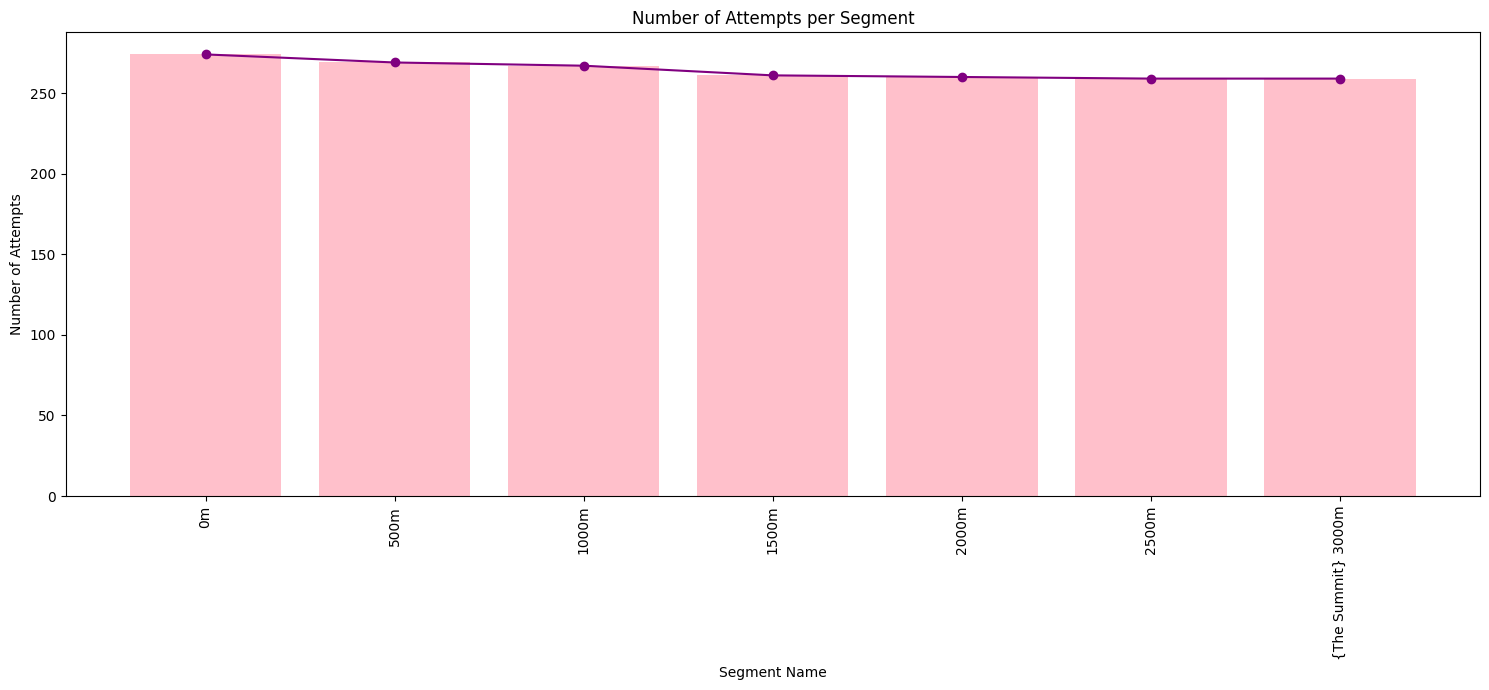

In [13]:
#subset the plot

plt.figure(figsize=(15, 7))
plt.bar(counts_finale.columns, counts_finale.values[0], color='pink')
plt.plot(counts_finale.columns, counts_finale.values[0], '-o', color='purple')
plt.xticks(rotation=90)
plt.xlabel("Segment Name")
plt.ylabel("Number of Attempts")
plt.title("Number of Attempts per Segment")
plt.tight_layout()
plt.show()

/tmp/ipython-input-92693067.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(counts_finale, rotation=45)


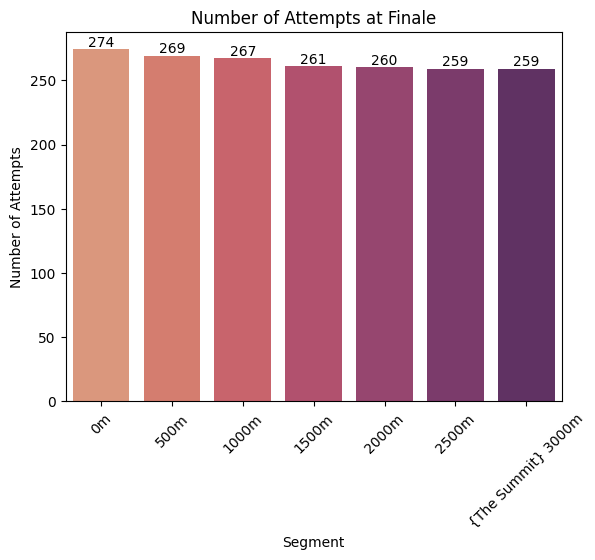

In [27]:
#subset the plot, this time in seaborn

g = sns.barplot(counts_finale, palette="flare")
g.set_xticklabels(counts_finale, rotation=45)
g.set_title("Number of Attempts at Finale")
g.set_xlabel("Segment")
g.set_ylabel("Number of Attempts")
for container in g.containers:
  g.bar_label(container)

plt.show()

So despite looking like the number of runs at the end are equal on the larger plot, zooming in reveals a slight decrease over attempts towards the final segment.

## Personal Best vs. BestSegmentTime

Inspecting the raw .lss file, it saves a "Personal Best" time in a separate child node from the list of attempts ("SegmentHistory" child node within "Segment")

Another child node, "BestSegmentTime", is saved separate from "Personal Best" and the "SegmentHistory."

"Personal Best" is the quickest time on an attempt that went to completion, whereas "BestSegmentTime" is equal to the minimal (non-null) value of a segment whether or not the whole run was completed. A "BestSegmentTime" may be quicker than a "Personal Best" in training sequences, where a speedrunner is repeating the same segment over and over.

Considering this, are the "BestSegmentTime" times in this .lss file equal to, less than (e.g. faster than), or greater than the "Personal Best" times?

In [44]:
#first, drop attempt_id
runs_df = speedrun_df.drop('attempt_id', axis=1)


#collect the smallest/min value of each segment
runs_min = pd.DataFrame(runs_df.min())
runs_min

,0
Prologue,27.625003
Start1,15.690999
Crossing,20.893000
{Forsaken City} Chasm,17.799001
Start2,32.759000
Intervention,54.723001
{Old Site} Awake,7.530999
Start3,60.638999
Huge Mess,90.525000
Elevator Shaft,29.001998


In [49]:
#calculate and collect running sum of the min runs
min_list = np.cumsum(runs_min)
min_list

,0
Prologue,27.625003
Start1,43.316002
Crossing,64.209002
{Forsaken City} Chasm,82.008003
Start2,114.767003
Intervention,169.490003
{Old Site} Awake,177.021003
Start3,237.660002
Huge Mess,328.185002
Elevator Shaft,357.187000


In [29]:
#get ordered segment names

segment_names = []
segment_element = []
for seg in segments_node:
    if seg.tag == "Segment":
        segment_element.append(seg)
        name_node = next((c for c in seg if c.tag == "Name"), None)
        segment_names.append(name_node.text if name_node is not None else "")


#collect PB using GameTime
pb_list = []

for seg in segments_node:
    split_times = next((c for c in seg if c.tag == "SplitTimes"), None)
    val = None
    if split_times is not None:
      for st in split_times:
        if st.tag != "SplitTime":
          continue
        if st.get("name") == "Personal Best":
          txt = next((c.text for c in st if c.tag == "GameTime"), None)
          val = parse_time_to_s(txt)
    pb_list.append(val)

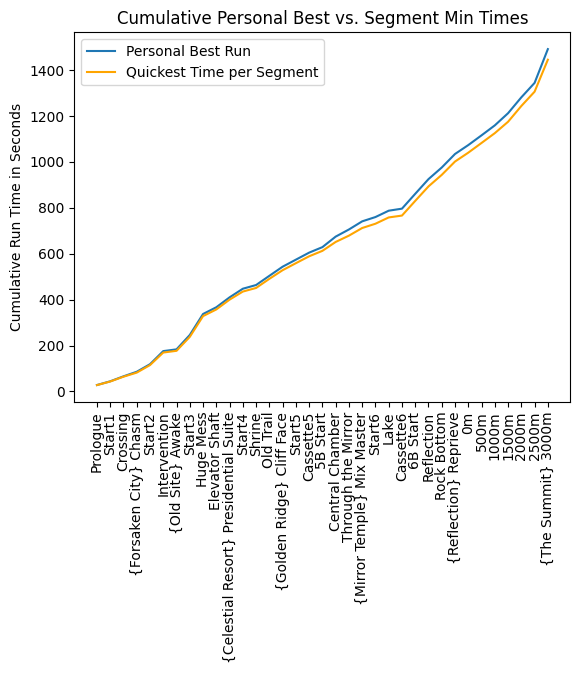

In [56]:
segment = np.array(counts.columns)

pb_array = np.array(pb_list)

plt.plot(segment, pb_array)
plt.plot(segment, min_list, color="orange")
plt.legend(['Personal Best Run','Quickest Time per Segment'])
plt.xticks(rotation=90)
plt.ylabel("Cumulative Run Time in Seconds")
plt.title("Cumulative Personal Best vs. Segment Min Times")
plt.show()

In [58]:
temp_df = pd.DataFrame()
temp_df["Min"] = runs_df.min()
temp_df['PB'] = pb_array

min_cum = []
prev = None
for time in pb_array:
  if time is None:
    min_cum.append(None)
    prev = None
    continue
  if prev is None:
    min_cum.append(prev)
  else:
    min_cum.append(time - prev)

  prev = time

temp_df["Min_Cum"] = np.array(min_cum)
temp_df.loc[temp_df["Min_Cum"] == 'null', "Min_Cum"] = 0.00

temp_df

,Min,PB,Min_Cum
Prologue,27.625003,27.948001,None
Start1,15.690999,44.149001,16.201
Crossing,20.893000,65.824001,21.675
{Forsaken City} Chasm,17.799001,85.731002,19.907001
Start2,32.759000,118.677001,32.945999
Intervention,54.723001,175.780002,57.103001
{Old Site} Awake,7.530999,183.345002,7.565
Start3,60.638999,245.956001,62.610999
Huge Mess,90.525000,337.450001,91.494
Elevator Shaft,29.001998,366.775001,29.325


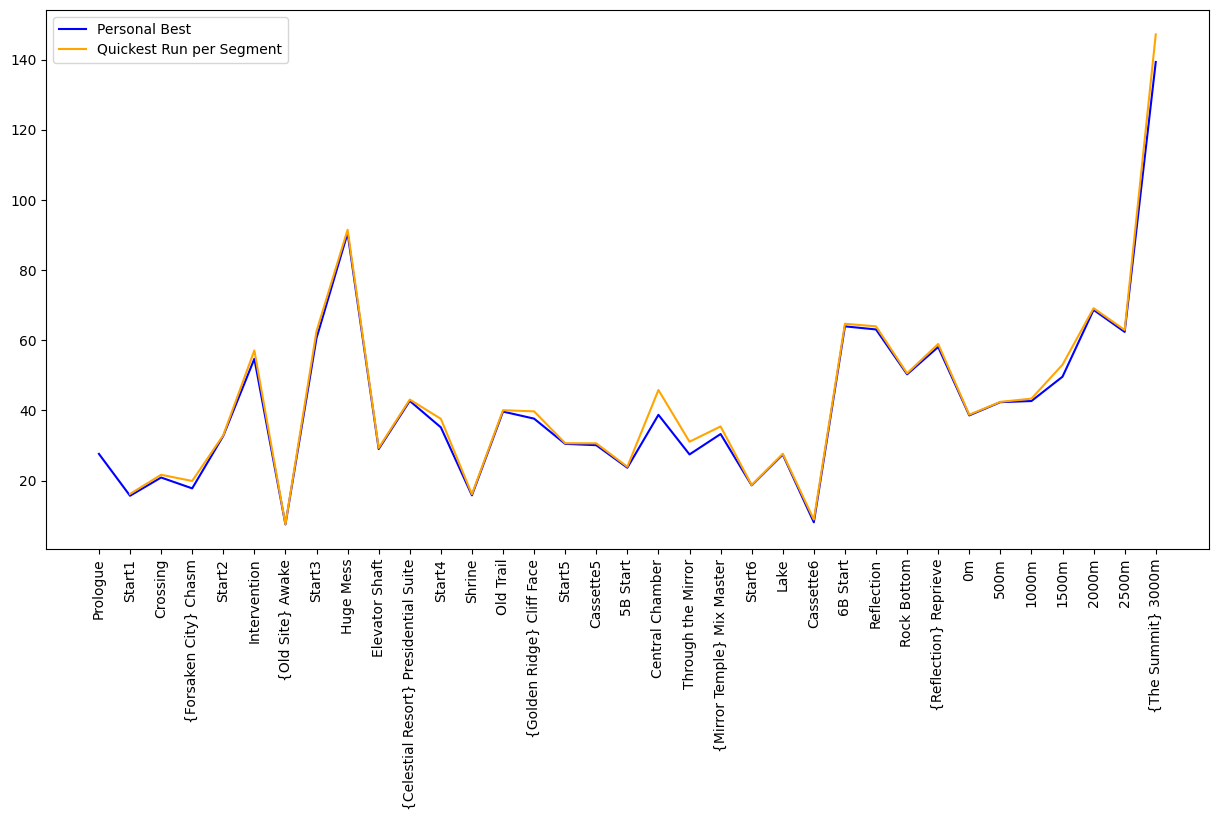

In [59]:
plt.figure(figsize=(15, 7))
plt.plot(temp_df["Min"], color = 'blue')
plt.plot(temp_df["Min_Cum"], color = 'orange')
plt.legend(['Personal Best', 'Quickest Run per Segment'])
plt.xticks(rotation=90)
plt.show()

# Animating Run Attempts

The python package Manim is a video-generating package that can visualize plots.
Animating plots is achievable in packages like plotly or matplotlib, but Manim outputs automatically into .mp4 files (useful for YouTubers, such as the original stakeholder of the project) and is smoother in comparison to other libraries.

Manim must first be configured (specifically here, to operate in Google Colab)

In [1]:
!sudo apt update
!sudo apt install libcairo2-dev \
    texlive texlive-latex-extra texlive-fonts-extra \
    texlive-latex-recommended texlive-science \
    tipa libpango1.0-dev
!pip install manim
!pip install IPython==8.21.0

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 https://cli.github.com/packages stable InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,530 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,289 kB

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 810.0/810.0 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.1 MB/s eta 0:00:00
  Attempting uninstall: IPython
    Found existing installation: ipython 7.34.0
    Uninstalling ipython-7.34.0:
      Successfully uninstalled ipython-7.34.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython==7.34.0, but you have ipython 8.21.0 which is incompatible.


In [61]:
#after configuration, import manim

from manim import *

/usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):


In [83]:
#use cell magic to run in the notebook
#-qm outputs the video in medium definition (vs. low -ql, or high -hq definition)
%%manim -qm RunsBarChart

class RunsBarChart(Scene):
  def construct(self):
    initial_values = [3794,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    final_values = counts.values[0]

    chart = BarChart(
        initial_values,
        bar_names = range(1,34),
        y_range = [0, 4000, 500],
    )

    x_label = Text("Segment").scale(0.5)
    x_label.next_to(chart.x_axis, DOWN, buff=0.5)

    title = Text("Number of Attempts per Segment").scale(0.8)
    title.next_to(chart, UP, buff = 0.8)

    chart.shift(RIGHT * 0.5)
    self.add(chart, x_label, title)

    self.play(Create(chart))
    self.wait(2)

    self.play(chart.animate.change_bar_values(final_values), run_time=3)
    self.wait(3)

Manim Community v0.19.0

[11/13/25 14:36:03] INFO     Animation 0 : Partial movie file written in                   ]8;id=517404;file:///usr/local/lib/python3.12/dist-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=995920;file:///usr/local/lib/python3.12/dist-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/content/media/videos/content/720p30/partial_movie_files/Run                         
                             sBarChart/2016333726_109609300_2632232362.mp4'                                        

[11/13/25 14:36:05] INFO     Animation 1 : Partial movie file written in                   ]8;id=272943;file:///usr/local/lib/python3.12/dist-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=560372;file:///usr/local/lib/python3.12/dist-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/content/media/videos/content/720p30/partial_movie_files/Run                         
                             sBarChart/543634251_2872842549_3729413177.mp4'                                        

[11/13/25 14:36:17] INFO     Animation 2 : Partial movie file written in                   ]8;id=393009;file:///usr/local/lib/python3.12/dist-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=69598;file:///usr/local/lib/python3.12/dist-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/content/media/videos/content/720p30/partial_movie_files/Run                         
                             sBarChart/543634251_1073507990_281917507.mp4'                                         

[11/13/25 14:36:20] INFO     Animation 3 : Partial movie file written in                   ]8;id=80012;file:///usr/local/lib/python3.12/dist-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=57268;file:///usr/local/lib/python3.12/dist-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/content/media/videos/content/720p30/partial_movie_files/Run                         
                             sBarChart/543634251_4277570474_1933367045.mp4'                                        

                    INFO     Combining to Movie file.                                      ]8;id=781553;file:///usr/local/lib/python3.12/dist-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=336932;file:///usr/local/lib/python3.12/dist-packages/manim/scene/scene_file_writer.py#739\739]8;;\

                    INFO                                                                   ]8;id=276869;file:///usr/local/lib/python3.12/dist-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=24331;file:///usr/local/lib/python3.12/dist-packages/manim/scene/scene_file_writer.py#886\886]8;;\
                             File ready at                                                                         
                             '/content/media/videos/content/720p30/RunsBarChart.mp4'                               
                                                                                                                   

                    INFO     Rendered RunsBarChart                                                     ]8;id=502673;file:///usr/local/lib/python3.12/dist-packages/manim/scene/scene.py\scene.py]8;;\:]8;id=256857;file:///usr/local/lib/python3.12/dist-packages/manim/scene/scene.py#255\255]8;;\
                             Played 4 animations                                                                   